<blockquote><h2><b>Abstract</b></h2></blockquote>

The basis of this project is to study the spread of corona virus by simulating random walk SIR model and comparing them with the ODE based SIR model. The comparison showed that the overall results were nearly identical.

SI model was developed in a fixed coordinate range compartment to analyze the spread of infection from one walker to another under various initial conditions. Then, the model was further improved by adding a recover compartment (R) to recover some walker and build the SIR model. Some walkers become infected when they change positions in the x and y directions, and subsequently, they begin to recover. The results of simulated SIR model were verified by comparing them with the ODE-based SIR model. In the final implementation several scenarios—such as older people having a higher risk of death, vaccination of the population, a new infection wave where walkers could contract the disease again, were added to the Random Walk model. Finally the model was compared with real-world data.

<blockquote><h2><b>Introduction</b></h2></blockquote>

The Corona Virus is an outbreak of disease that spans multiple countries and affects large numbers of people. It easily spreads from person to person. It is hard to directly predict how quickly a pandemic will spread in a population. To achieve better prevention and analysis, this project establishes the SIR model to understand the transmission dynamics of COVID-19 disease. The SIR model is structured on the numbers of susceptible (S), infectious (I), and recovered individuals (R) [1]. One of the major assumptions of the SIR model is that there is a homogeneous mixing of the susceptible and infected populations and that the overall population remains constant throughout time. The susceptible population in the SIR model monotonically declines to zero [2]. These SIR models based on ODEs are,


\begin{equation}
\begin{split}
\tag{1}
\frac{dS(t)}{dt}=\ {-}\beta(t).\frac{S(t)I(t)}{N}
\\
\\
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\tag{2}
\frac{dI(t)}{dt}=\beta(t).\frac{S(t)I(t)}{N}\ {-}\frac{1}{\tau sick}. \ {I(t)} 
\\
\\
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\tag{3}
\frac{dR(t)}{dt}=\ {-}\frac{1}{\tau sick}. \ {I(t)}
\\
\\
\end{split}
\end{equation}

Where $\beta$ represents the infection rate and $\tau sick$ represents the mean time of infection, i.e., the time until recovery. If $\tau sick$ is infinte, a person stays sick forever, and equations (1)-(3) reduce to the SI-model [4]. Where $\ {N}$ is the sum of $\ {S}$, $\ {I}$ and $\ {R}$.

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as r
import scipy as sp
import scipy.integrate
import pandas as pd

In [2]:
class RandomWalkEpidemicSimulator:
    
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.
    Each walker has a disease state which is represented by an
    integer number. Also, a set of integer (x, y)-coordinates are
    stored for each walker. The possible coordinates are:
    {0, 1, ..., Lx-1} in the x-direction
    {0, 1, ..., Ly-1} in the y-direction
    It is only possible to move North, South, East, or West. If a
    walker attempts to move outside of the physical domain, nothing
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(self, population_size, sim_time = 300, no_init_infected =10, nx=50, ny=50, q=0.9,p = 0.00, d= 0.00,dt = 1, pop_old = 200, own_scenario = False):
        """
        :param population_size: The total number of people (N).
        :param sim_time: The total time of the simulation
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        :param p: The probability of getting recovered from the disease.
        :param d: The probability of dying from the disease.
        :param dt: Time step of each iteration
        :param pop_old: size of old population.
        """
        self.N = population_size
        self.I0 = no_init_infected
        self.nx = nx
        self.ny = ny
        self.infection_probability = q
        self.recover_probability = p
        self.dying_probability = d
        self.S0 = self.N - self. I0 #Initially susceptible
        self.nxy = self.nx = self.ny
        self.SUSCEPTIBLE = 0 
        self.INFECTIOUS = 1
        self.Recovered = 2
        self.DEAD = 3
        self.OLD = 2
        self.YOUNG = 1
        self.dt = dt
        self.sim_t = sim_time
        self.time = np.arange(0, self.sim_t + self.dt, self.dt)
        self.own_scenario = own_scenario
        self.pop_old = pop_old


    def initial_state(self):
        '''
        The function randomy place walkers in the specified grid space.
        From the total population given number of individuals are randomly set as infected
        Similarly given number of old population is randomly set as old
        '''      
        
        self.Walkers = np.random.randint(0, [self.nx, self.ny], size=(self.N, 2)) #Random coordinates given to each walker
        self.State =np.zeros(self.N,dtype=int)
        infection = np.random.randint(0, self.N, self.I0) #Randomly given number of walkers are made initially infected
        for inf in infection: self.State[inf] = self.INFECTIOUS   # Randomly given number of people are made infected ones
        if self.own_scenario:
            self.Age =np.ones(self.N,dtype=int)  # array defined to store the age of people
            old = np.random.randint(0, self.N, self.pop_old)
            for o in old: self.Age[o] = self.OLD # Randomly given number of people are set at old age



    def next_pos(self):  
        '''
        After each time step the walkers are randomly moved to the next position, 
        in any one of the 4 directions; North, South, East West.
        '''
        next_pos=[]

        for i in range(len(self.Walkers)):
            x = r.choice([(0,1),(0,-1),(1,0),(-1,0)]) #Random step chosen for each walker in any one direction
            next_pos.append(x)
        
        self.Walkers_Old_ = self.Walkers.copy()
        self.Walkers += next_pos
        if self.own_scenario:
            self.Walkers[self.State == self.DEAD] = self.Walkers_Old_[self.State == self.DEAD] #Dead are placed back to the spot where they died
            z = np.where(self.Age == self.OLD)[0] # mobility of old people moving is set to 50%
            mobility = np.random.uniform(0,1, len(z))
            x = z[mobility > 0.5]
            self.Walkers[x] = self.Walkers_Old_[x]



    def illegal_pos(self):
        '''
        If a walker moves out of the specified grid space, he is moved back to the old position.
        '''
        x_illegal = np.logical_or(self.Walkers[:,0]<0,self.Walkers[:,0]>self.nxy)
        y_illegal = np.logical_or(self.Walkers[:,1]<0,self.Walkers[:,1]>self.nxy)
        wrong_direction = np.logical_or(x_illegal,y_illegal)
        self.Walkers[wrong_direction] = self.Walkers_Old_[wrong_direction] #Walkers out of grid are placed back to old coordinates


    def collision(self):
        '''
        The funtion checks for coordinates where both infected and susceptible individuals are present
        Monte Carlo theory is used to see if a non-infected individual will get infected
        If more than one infected walkers are present the probability of getting infected is checked that many times.
        '''
        S_coord = self.Walkers[self.State == self.SUSCEPTIBLE] #Coordinates of Susceptible walkers stored
        s = np.where(self.State == self.SUSCEPTIBLE)[0] #susceptible walkers are identified
        I_coord = self.Walkers[self.State == self.INFECTIOUS]  #Coordinates of Infected walkers stored
        for i, cord in enumerate(S_coord):
            infected_same = np.where((I_coord[:, 0] == cord[0]) & (I_coord[:, 1] == cord[1]))[0] #Coordinates found where susceptible individuals are present with infected ones
            x = len(infected_same) # Check if more than 1 infected individuals are present at a point
            if x == 0:
                continue
            else:
                u = np.random.uniform(0, 1, x)   #probaility array is made as the number of infected walkers at a coordinate, the probability of infection needs to be calculated that many times.
                if np.any(u<self.infection_probability):
                    self.State[s[i]] = self.INFECTIOUS


    def collision_own_scenario(self):
        Co_ord = self.Walkers[np.logical_or(self.State == self.SUSCEPTIBLE, self.State == self.Recovered)]  #Coordinates of Susceptible and recovered walkers stored
        I_coord = self.Walkers[self.State == self.INFECTIOUS]
        s_r = np.where(np.logical_or(self.State == self.SUSCEPTIBLE, self.State == self.Recovered))[0]
        for i, cord in enumerate(Co_ord):
            infected_same = np.where((I_coord[:, 0] == cord[0]) & (I_coord[:, 1] == cord[1]))[0]
            x = len(infected_same)
            if x == 0:
                continue
            else:
                u = np.random.uniform(0, 1, x)
                if (np.any(u<self.infection_probability)) and (self.State[s_r[i]] == self.SUSCEPTIBLE):
                    self.State[s_r[i]] = self.INFECTIOUS # State changed from susceptible to infected
                elif (np.any(u<(self.infection_probability*.5))) and (self.State[s_r[i]] == self.Recovered):  #recovered are reinfected with 50% of original infection probability
                    self.State[s_r[i]] = self.INFECTIOUS


    def recoverd(self):
        '''
        Recovered compartment is added to the model.
        The function checks for each infected individual the probabilty of getting recovered.
        If recovered the state of walker is changed from infected to recovered
        it returns arrays of coordinates for each state.
        '''
        infected  = np.where(self.State == self.INFECTIOUS)[0] #Number of infected individuals found
        u = np.random.uniform(0, 1, len(infected)) #Random number generated for each infected person
        for i, inf in enumerate(infected):
            if u[i]<self.recover_probability: 
                self.State[inf] = self.Recovered

        infected_=self.Walkers[self.State== self.INFECTIOUS] #Coordinates of infected
        suseptible_=self.Walkers[self.State== self.SUSCEPTIBLE]  #Coordinates of susceptible
        recovered_ = self.Walkers[self.State == self.Recovered]  #Coordinates of recovered

        return suseptible_, infected_, recovered_

    def life_decider(self):
        infected  = np.where(self.State == self.INFECTIOUS)[0]

        recover = np.random.uniform(0,1,len(infected))
        dying = np.random.uniform(0,1,len(infected))
        for i in range(len(infected)):
            if (recover[i]< self.recover_probability/2) and (self.Age[infected[i]] == self.OLD): #Recover probability reduced by 50% for old population
                self.State[infected[i]] = self.Recovered

            elif recover[i] < self.recover_probability and self.Age[infected[i]] == self.YOUNG: #Recover probabiliy for young population
                self.State[infected[i]] = self.Recovered

            elif dying[i]< self.dying_probability * 1.5 and self.Age[infected[i]] == self.OLD: #Dying probability increased by 50% for old population
                self.State[infected[i]] = self.DEAD

            elif dying[i] < self.dying_probability and self.Age[infected[i]] == self.YOUNG: #Dying probabiliy for young population
                self.State[infected[i]] = self.DEAD

        infected_=self.Walkers[self.State== self.INFECTIOUS]
        suseptible_ = self.Walkers[self.State == self.SUSCEPTIBLE]
        recovered_ = self.Walkers[self.State == self.Recovered]
        dead_young = self.Walkers[np.logical_and(self.State == self.DEAD, self.Age == self.YOUNG)]
        dead_old = self.Walkers[np.logical_and(self.State == self.DEAD, self.Age == self.OLD)]
        dead_total = self.Walkers[self.State == self.DEAD]

        return suseptible_, infected_, recovered_, dead_young, dead_old, dead_total



    def Show_walkers(self):
        '''
        plots a scatter plot, to show the walkers.
        Different states are shown with different size and color.
        '''
        for i in self.time: #Solver initialized for each time step
            self.next_pos()
            self.illegal_pos()
            if self.own_scenario:
                self.collision_own_scenario()
                sus, inf, rec, die_y, die_o, _ = self.life_decider()
            else:
                self.collision()
                sus, inf, rec = self.recoverd()

            if i%100 == 0: # To show plots at every 100th time step only
                    plt.figure(figsize= (12, 6))
                    plt.scatter(inf[:,0],inf[:,1], s = 50, c = 'r', label = 'Infected')
                    plt.scatter(rec[:,0],rec[:,1], s = 30, c = 'g', label = "Recovered")
                    plt.scatter(sus[:,0],sus[:,1], s = 20, c = 'b', label = "Susceptible")
                    if self.own_scenario:
                        plt.scatter(die_y[:,0],die_y[:,1], s = 20, c = 'black', label = "Dead_Young")
                        plt.scatter(die_o[:,0],die_o[:,1], s = 20, c = 'brown', label = "Dead_Old")

                    plt.title('Walker positions at {}th time step.\nWith initial infections = {}'.format(i, self.I0))
                    plt.legend()
                    plt.xlabel('x')
                    plt.ylabel('y')



    
    '''def Show_walkers_old(self):      

        if self.own_scenario:
            for i in self.time: #Solver initialized for each time step
                self.next_pos()
                self.illegal_pos()
                self.collision_own_scenario()
                sus, inf, rec, die_y, die_o, _ = self.life_decider()
                
    
                if i%100 == 0:
                    plt.figure(figsize= (12, 6))
                    plt.scatter(inf[:,0],inf[:,1], s = 60, c = 'r', label = 'Infected')
                    plt.scatter(sus[:,0],sus[:,1], s = 40, c = 'b', label = "Susceptible")
                    plt.scatter(rec[:,0],rec[:,1], s = 30, c = 'g', label = "Recovered")
                    plt.scatter(die_y[:,0],die_y[:,1], s = 20, c = 'black', label = "Dead_Young")
                    plt.scatter(die_o[:,0],die_o[:,1], s = 20, c = 'brown', label = "Dead_Old")
                    plt.title('Walker positions at {}th time step.\nWith initial infections = {}'.format(i, self.I0))
                    plt.legend()
                    plt.xlabel('x')
                    plt.ylabel('y')
        else:
            for i in self.time: #Solver initialized for each time step
        
                self.next_pos()
                self.illegal_pos()
                self.collision()
                sus, inf, rec = self.recoverd()      
                if i%100 == 0: # To show plots at every 100th time step only
                    plt.figure(figsize= (12, 6))
                    plt.scatter(inf[:,0],inf[:,1], s = 50, c = 'r', label = 'Infected')
                    plt.scatter(rec[:,0],rec[:,1], s = 30, c = 'g', label = "Recovered")
                    plt.scatter(sus[:,0],sus[:,1], s = 20, c = 'b', label = "Susceptible")

                    plt.title('Walker positions at {}th time step.\nWith initial infections = {}'.format(i, self.I0))
                    plt.legend()
                    plt.xlabel('x')
                    plt.ylabel('y')'''


    def Solver(self):
        '''
        The solver function runs for the total simulation time
        After each time step the number of walkers in each state: Susceptible, Infected, Recovered, Dead
        is calculated and appended in an array
        The funtion return arrays for each state, giving number of walkers in that state at each time step
        '''
        susceptible_list=[]
        infected_list=[]  
        recovered_list = []             
        for t in self.time:
            self.next_pos()  
            self.illegal_pos()
            self.collision()
            sus, inf, rec= self.recoverd()
            susceptible_list.append(len(sus))
            infected_list.append(len(inf))
            recovered_list.append(len(rec))
            
        return np.array(susceptible_list), np.array(infected_list), np.array(recovered_list)

    def new_wave(self):
        z = np.where(np.logical_or(self.State == self.SUSCEPTIBLE, self.State == self.Recovered))[0]
        x = np.random.choice(z, size= 4) #Randomly 4 extra individuals are infected
        #print('z:',z, 'x: ', x)
        self.State[x] = self.INFECTIOUS

        
    def solver_own_scenario(self):
        susceptible_list=[]
        infected_list=[]  
        recovered_list = []
        dead_y_list = []
        dead_old_list = []
        dead_t_list = []

        for t in self.time: #A new wave of infection is introduced
            if t> 400 and t < 500:
              self.new_wave()

            if t == 50 and t == 450: #Vaccination effect, probability of infection reduced
              self.infection_probability = self.infection_probability*0.5
            elif t == 150 and t == 550: #effect of vaccination diminishes, (immunity from vaccination minimized)
                self.infection_probability = self.infection_probability*2
            self.next_pos()  
            self.illegal_pos()
            self.collision()
            sus, inf, rec, die_y, die_o, die_t = self.life_decider()
            susceptible_list.append(len(sus))
            infected_list.append(len(inf))
            recovered_list.append(len(rec))
            dead_y_list.append(len(die_y))
            dead_old_list.append(len(die_o))
            dead_t_list.append(len(die_t))

        return np.array(susceptible_list), np.array(infected_list), np.array(recovered_list),np.array(dead_y_list),np.array(dead_old_list), np.array(dead_t_list)
    
    def Iter_solver(self, iter):
        '''
        Runs the solver upto given number of iterations
        at each iteration the results are appended to another array, which stores the number of walkers(in each state) for every time step for each iteration.
        '''
        if self.own_scenario:
            sus = []
            inf = []
            rec = []
            die = []
            for i in range(iter):
                self.initial_state()
                s, i, r,_ ,_ ,d = self.solver_own_scenario()
                sus.append(s)
                inf.append(i)
                rec.append(r)
                die.append(d)

            return np.array(sus),np.array(inf), np.array(rec), np.array(die)
        else:
            hea=[]                                       
            inf=[]          
            rec=[]                  
            for i in range(iter):
                self.initial_state()
                s,i,r=self.Solver()
                hea.append(s)   
                inf.append(i) 
                rec.append(r)

            return np.array(hea),np.array(inf), np.array(rec)


    def mean_std(self, iter):
        '''
        Calculates the mean and standard devaition of number of walkers at each time step
        '''
        if self.own_scenario:
            sus, inf,  rec, die= self.Iter_solver(iter)
            
            susceptible_mean = [np.mean(k) for k in zip(*sus)]
            infected_mean = [np.mean(k) for k in zip(*inf)] 
            recovered_mean = [np.mean(k) for k in zip(*rec)]
            dead_mean = [np.mean(k) for k in zip(*die)]
            susceptible_std = [np.std(k) for k in zip(*sus)]       
            infected_std = [np.std(k) for k in zip(*inf)]
            recovered_std = [np.std(k) for k in zip(*rec)]
            dead_std = [np.std(k) for k in zip(*die)]

            return susceptible_mean, infected_mean,recovered_mean, dead_mean, susceptible_std, infected_std, recovered_std, dead_std
        else:
            hea, inf,  rec= self.Iter_solver(iter)
            
            susceptible_mean = [np.mean(k) for k in zip(*hea)]
            infected_mean = [np.mean(k) for k in zip(*inf)] 
            recovered_mean = [np.mean(k) for k in zip(*rec)]
            susceptible_std = [np.std(k) for k in zip(*hea)]       
            infected_std = [np.std(k) for k in zip(*inf)]
            recovered_std = [np.std(k) for k in zip(*rec)]
            
            return susceptible_mean, infected_mean, susceptible_std, infected_std, recovered_mean, recovered_std
    

    def beta(self, susceptible_array, infected_array):
        '''
        Calculates disease transmission rate (beta)
        Data from Random Walk model is used to calculate the value
        First order approximation of  the derivative is used to find beta
        Returns an array with beta value for each time step
        '''
        s_old = self.S0
        beta_dt = []
        for i in range(len(self.time)):
          s_i = susceptible_array[i] * infected_array[i]
          if s_i == 0: #skip iteration if either population goes to zero (prevents divisible by zero error.)
            continue
          beta = -1*self.N*(susceptible_array[i] - s_old) / (s_i)
          beta_dt.append(beta)
          s_old = susceptible_array[i]

        return np.asarray(beta_dt)


    def tau_sick(self, infected_array, recovered_array):
        '''
        Calculates the mean infection time (tau_sick)
        Susceptible, Infected, and Recovered data from random walk is used to calculate the value
        Returns an array with tau value for each time step
        '''
        R_old = 0
        tau = []
        for i in range(len(self.time)):
            r_i = recovered_array[i] - R_old
            if r_i == 0: #skip iteration if no change in total recovered (prevents divisible by zero error.)
                continue
            tau_sick = infected_array[i] / r_i
            R_old = recovered_array[i]
            tau.append(tau_sick)
        
        return np.asarray(tau)

    def analytical_SI(self, beta):
        '''
        Calculates analytical solution to the SI based model
        '''
        infected = self.N/(1+((self.S0/self.I0)*np.exp(-1*beta*self.time)))
        susceptible = self.N - infected
        return susceptible, infected #Returns number of infected and susceptible for each time step
   
    def SIR_model(self, beta, tau_s):
        '''
        Calculaes the analytical solution to the SIR based model
        '''
        def rhs(X, t):
            S, I, R = X
            return [-beta*S*I/self.N, +beta*S*I/self.N - I/tau_s, +I/tau_s]
        X0 = [self.S0, self.I0, 0]
        sol = sp.integrate.odeint(rhs, X0, self.time)
        return sol

## Exercise 1
### Part 1
A single class is created above that has functions for each attribute of the solver, i.e , initial_state, next position, illegal position and collision

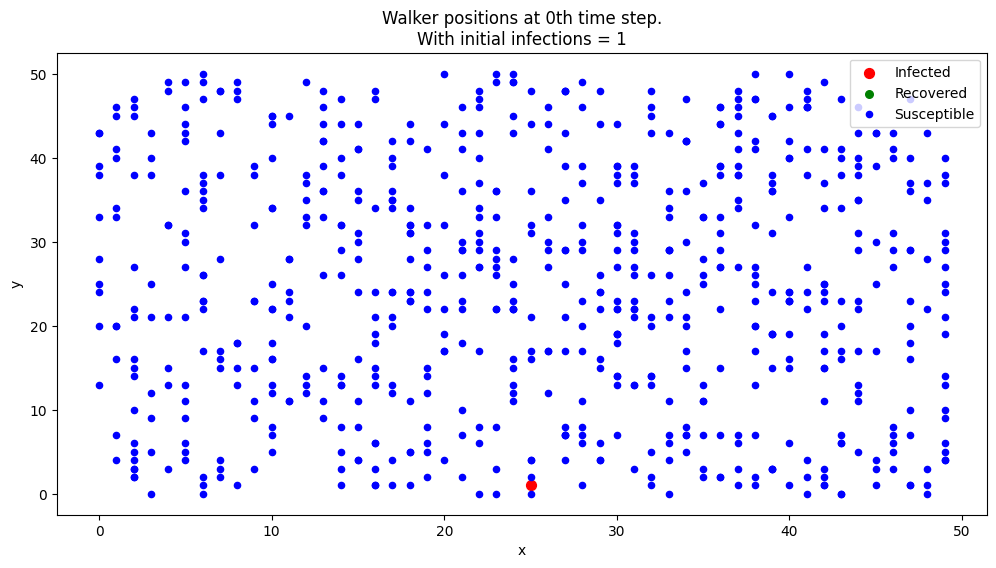

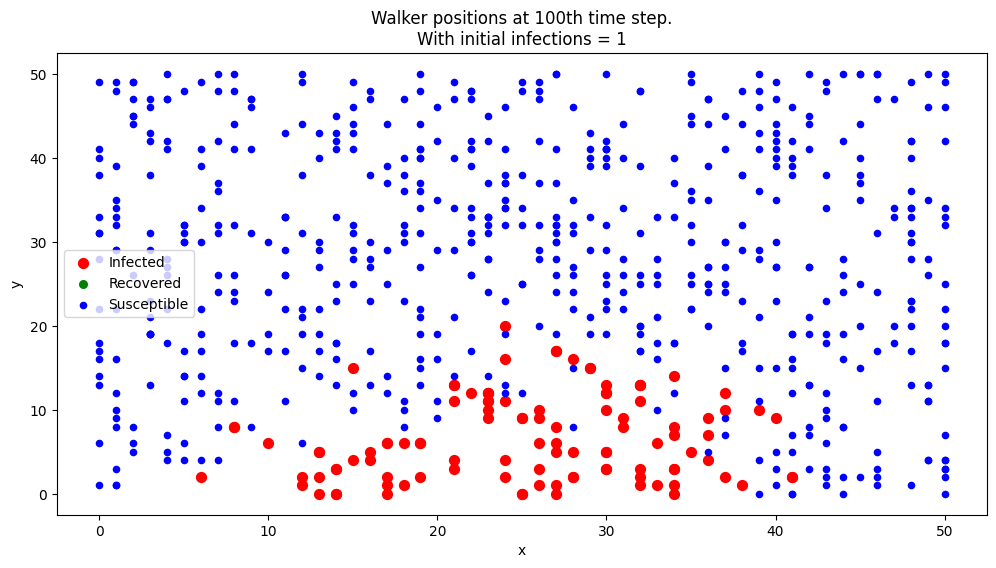

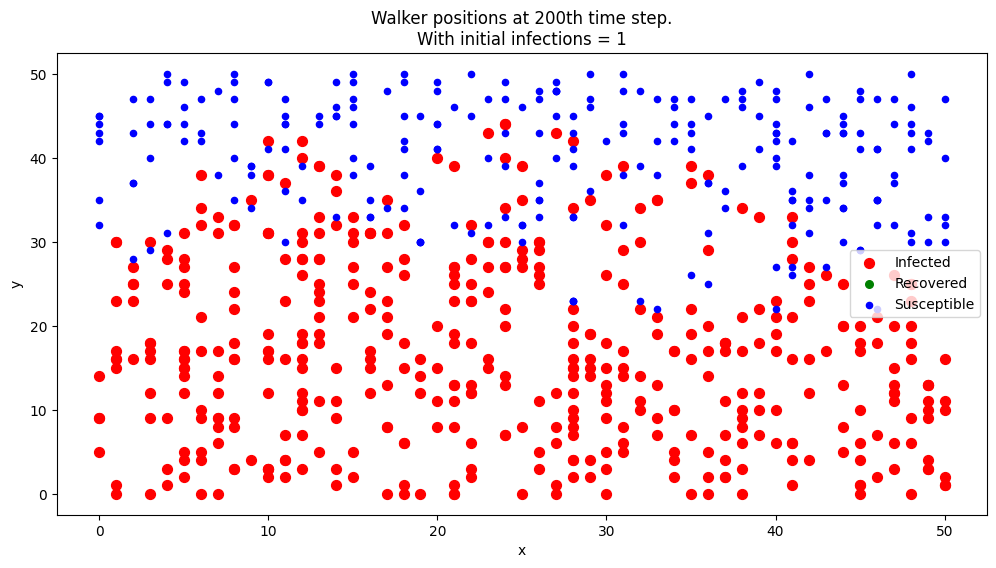

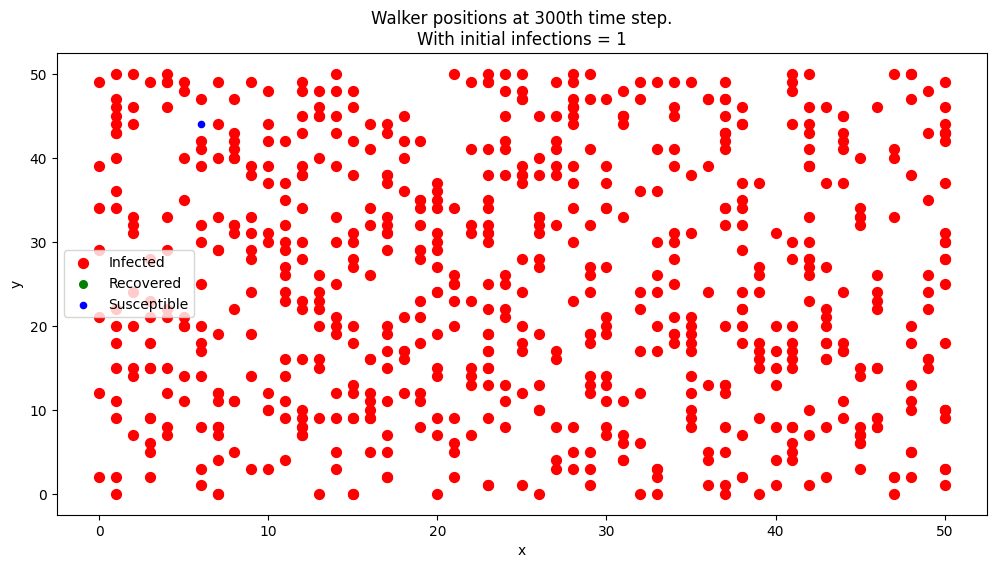

In [3]:
RW = RandomWalkEpidemicSimulator(683, no_init_infected= 1)
RW.initial_state() #Initial State initiated
RW.Show_walkers()

### Discussion
As it can be seen the infection starts to spread from the point where the initial infection takes place. It is interesting to see that if the initial infection is at the corner of the grid the spread of disease is slow as compared to if the infection was somewhat in the center.

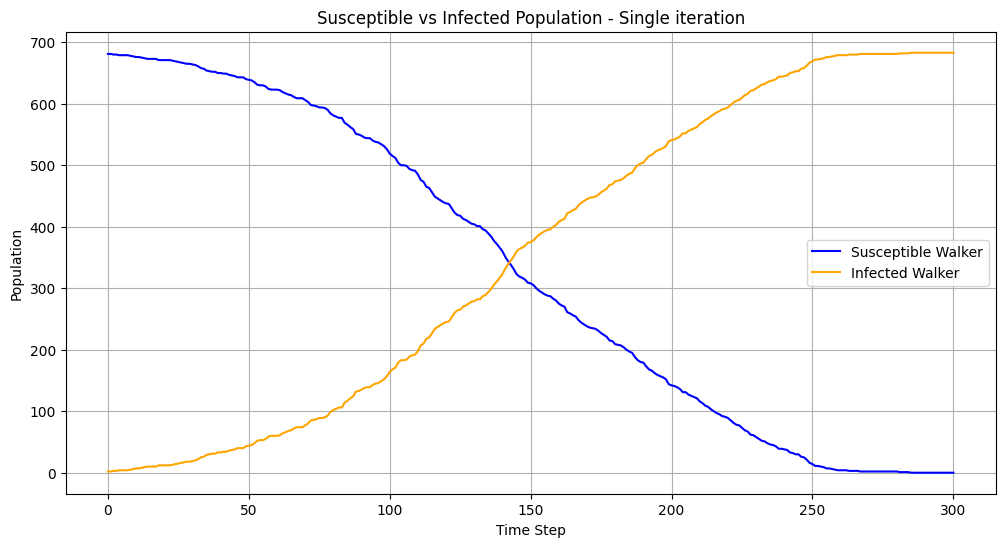

In [4]:
RW = RandomWalkEpidemicSimulator(683, no_init_infected= 1)
RW.initial_state()
suscep, Infect, _= RW.Solver()
#Plotting a single  simulation
plt.figure(figsize= (12,6))
plt.title('Susceptible vs Infected Population - Single iteration')
plt.plot(RW.time, suscep, color='blue',label='Susceptible Walker')
plt.plot(RW.time, Infect, color='orange',label='Infected Walker')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Part 2

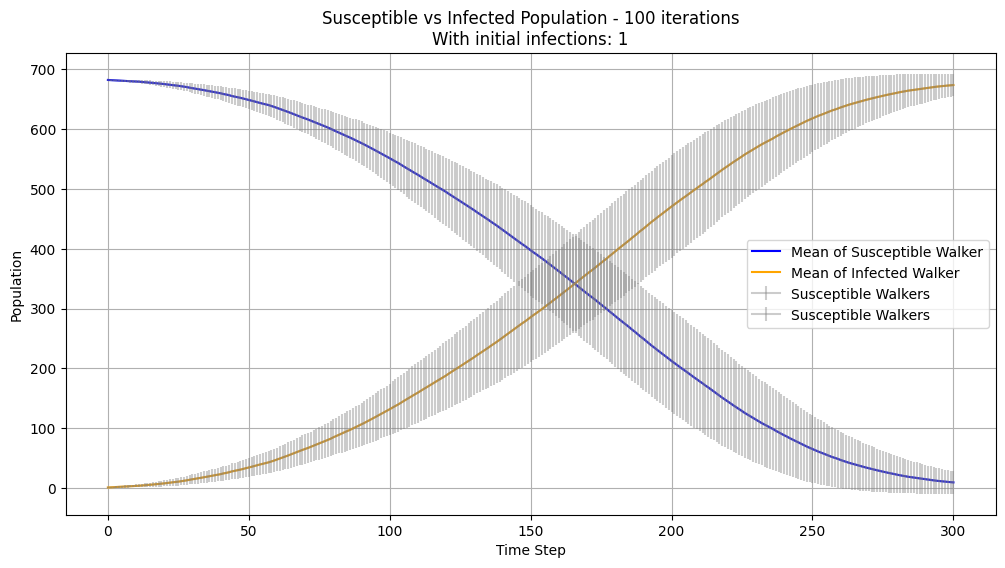

In [5]:
iter = 100
sim_t = 300
RW = RandomWalkEpidemicSimulator(683, no_init_infected= 1, sim_time= sim_t)
RW.initial_state()
susceptible_mean, infected_mean, susceptible_std, infected_std, _, _ = RW.mean_std(iter)

# Plotting
plt.figure( figsize = (12,6))
plt.title('Susceptible vs Infected Population - {} iterations\nWith initial infections: {}'.format(iter, RW.I0))
plt.plot(RW.time,susceptible_mean, color='blue',label='Mean of Susceptible Walker')
plt.plot(RW.time,infected_mean, color='orange',label='Mean of Infected Walker')
plt.errorbar(RW.time, susceptible_mean, susceptible_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, infected_mean, infected_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Discussion
A significant variation can be seen in the plot, due to the incorporation of randomness in the scenario. At about 170 time step the population of infected and healthy individuals becomes equal.

### Part 3

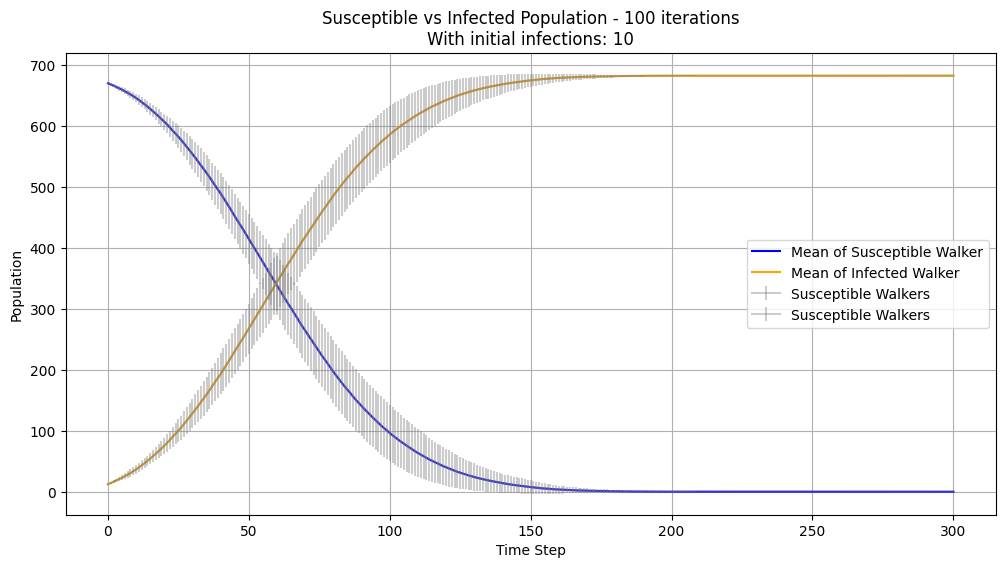

In [6]:
iter = 100
sim_t = 300
RW = RandomWalkEpidemicSimulator(683, no_init_infected= 10, sim_time= sim_t)
RW.initial_state()
susceptible_mean, infected_mean, susceptible_std, infected_std, _, _ = RW.mean_std(iter)

# Plotting
plt.figure( figsize = (12,6))
plt.title('Susceptible vs Infected Population - {} iterations\nWith initial infections: {}'.format(iter, RW.I0))
plt.plot(RW.time,susceptible_mean, color='blue',label='Mean of Susceptible Walker')
plt.plot(RW.time,infected_mean, color='orange',label='Mean of Infected Walker')
plt.errorbar(RW.time, susceptible_mean, susceptible_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, infected_mean, infected_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Discussion
As expected the total population gets infected earlier than with one infected individual. The population infected and healthy population becomes equal at an earlier time, i.e at 65 time step.

## Exercise 2
### Part 1

In [7]:
beta = RW.beta(susceptible_mean, infected_mean) #providing mean susceptible and infected from the RW simulation
#print(len(beta))
#Since delta t = 1
beta_constant = np.mean(beta)
print('The mean value of infection rate is: ',beta_constant)

The mean value of infection rate is:  0.06911551468442717


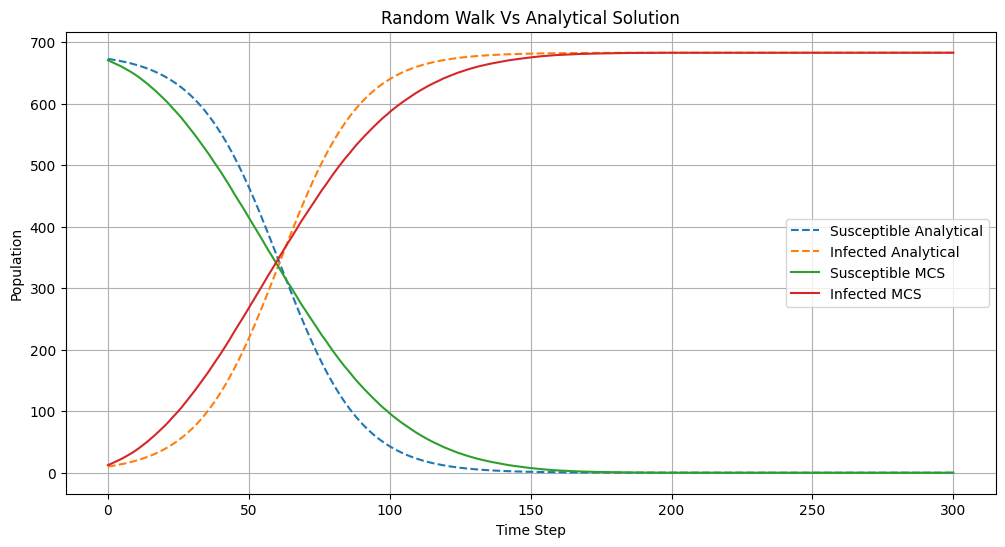

In [8]:
s_analytical, i_analytical = RW.analytical_SI(beta_constant)
plt.figure( figsize = (12,6))
plt.plot(RW.time, s_analytical, '--', label = 'Susceptible Analytical')
plt.plot(RW.time, i_analytical, '--', label = 'Infected Analytical')
plt.plot(RW.time, susceptible_mean, label = 'Susceptible MCS')
plt.plot(RW.time, infected_mean, label = 'Infected MCS')
plt.title('Random Walk Vs Analytical Solution')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Discussion
The RW model and analytical solutions are closely matched.

### Part 2 & 3

Adding Recovered compartment to the Random Walk model. In the above class a recovered function is created.


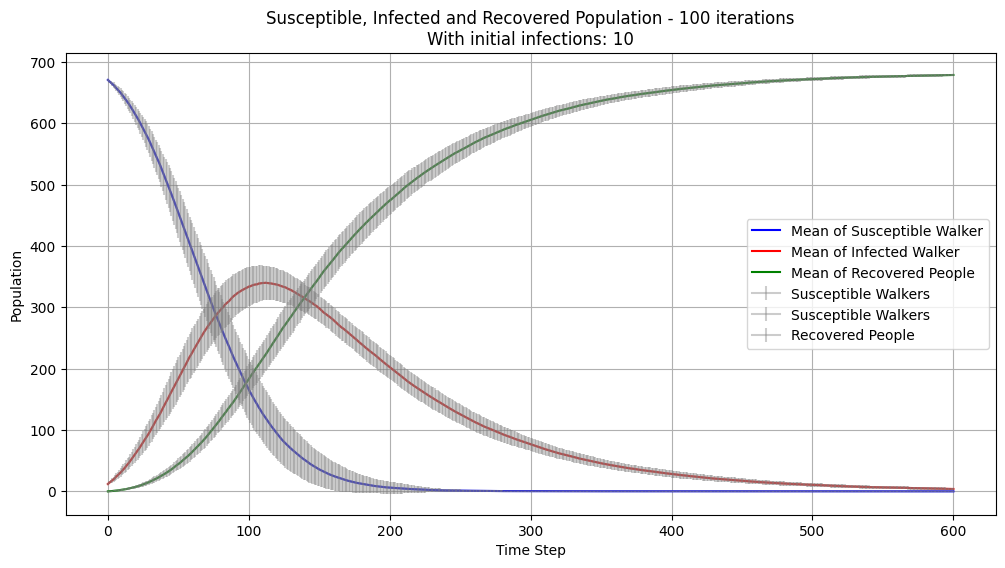

In [9]:
iter = 100
sim_t = 600
RW = RandomWalkEpidemicSimulator(683, no_init_infected= 10,p= 0.01,  sim_time= sim_t)
RW.initial_state()
susceptible_mean, infected_mean, susceptible_std, infected_std, recovered_mean, recovered_std = RW.mean_std(iter)

# Plotting
plt.figure( figsize = (12,6))
plt.title('Susceptible, Infected and Recovered Population - {} iterations\nWith initial infections: {}'.format(iter, RW.I0))
plt.plot(RW.time,susceptible_mean, color='blue',label='Mean of Susceptible Walker')
plt.plot(RW.time,infected_mean, color='red',label='Mean of Infected Walker')
plt.plot(RW.time,recovered_mean, color='green',label='Mean of Recovered People')
plt.errorbar(RW.time, susceptible_mean, susceptible_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, infected_mean, infected_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, recovered_mean, recovered_std, label = 'Recovered People',alpha=0.4,color='gray')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Discussion
Since infected can get recovered and cannot be re-infected, the infected population plumets to zero in this scenario, meanwhile the total poluation gets recovered after getting infected once.

### Part 4
Beta is recalculated since new compartment is created. tau_sick is calculated by the following first order approximation of the derivative: 
**INSERT EQUATION HERE**

In [10]:
beta = RW.beta(susceptible_mean, infected_mean)
#print('beat length: ',len(beta))
#Since delta t = 1
beta_constant = np.mean(beta)
print('The mean value of infection rate is: ',beta_constant)

tau_sick = RW.tau_sick(infected_mean, recovered_mean)
#print('tau_sick length: ',len(tau_sick))
tau_constant = np.mean(tau_sick)
print('The mean value of time of recovery is: ', tau_constant)

The mean value of infection rate is:  0.10218961326019012
The mean value of time of recovery is:  105.70811135619465


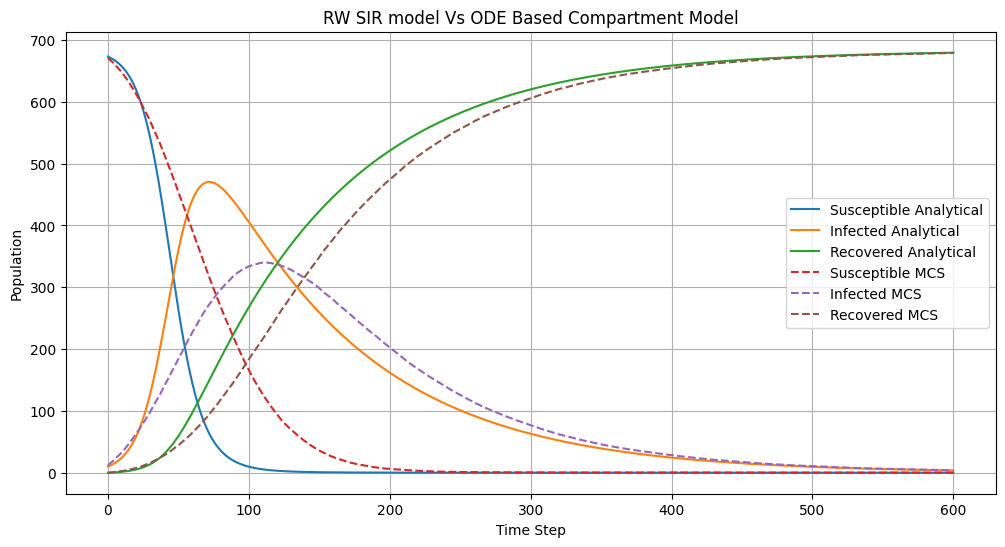

In [11]:
SIR = RW.SIR_model(beta_constant, tau_constant)
plt.figure(figsize= (12, 6))
plt.title('RW SIR model Vs ODE Based Compartment Model')
plt.plot(RW.time, SIR[:, 0], '-', label = 'Susceptible Analytical')
plt.plot(RW.time, SIR[:, 1], '-', label = 'Infected Analytical')
plt.plot(RW.time, SIR[:, 2], '-', label = 'Recovered Analytical')
plt.plot(RW.time, susceptible_mean, '--', label = 'Susceptible MCS')
plt.plot(RW.time, infected_mean, '--',label = 'Infected MCS')
plt.plot(RW.time, recovered_mean, '--',label = 'Recovered MCS')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

### Discussion
For each state; Healthy, Infected, Recovered, both models follow the same shape however, there is significant difference observed. May be a better approximation to the beta and tau could result in  less difference in the models.

##  Exercise 3
This modified model is incorporated within the basic scenario and adds the following features to the existing model:
1. Population is divided into two age groups; Young and Old
2. A new compartment is made of those who died from the infection
3. Different proability of dying and recovering is set for the two population groups.
4. Mobility of old population is reduced by reducing a chance of them moving by 50% in every iteration
5. The recovered can get reinfected with infection probability 50% less than the original infection probability
6. New infecton wave is intoroduced at 400th time step
7. The effect of vaccination is applied by reducing the infecton probability after a certain time step

From the population of 683, 200 members are set at old age and they have a 50% chance of moving in an iteration. The probability of getting re-infected from disease is 50% of the original probability. Probability of dying is set at 1%, while probability of recovering from the disease is set at 5%

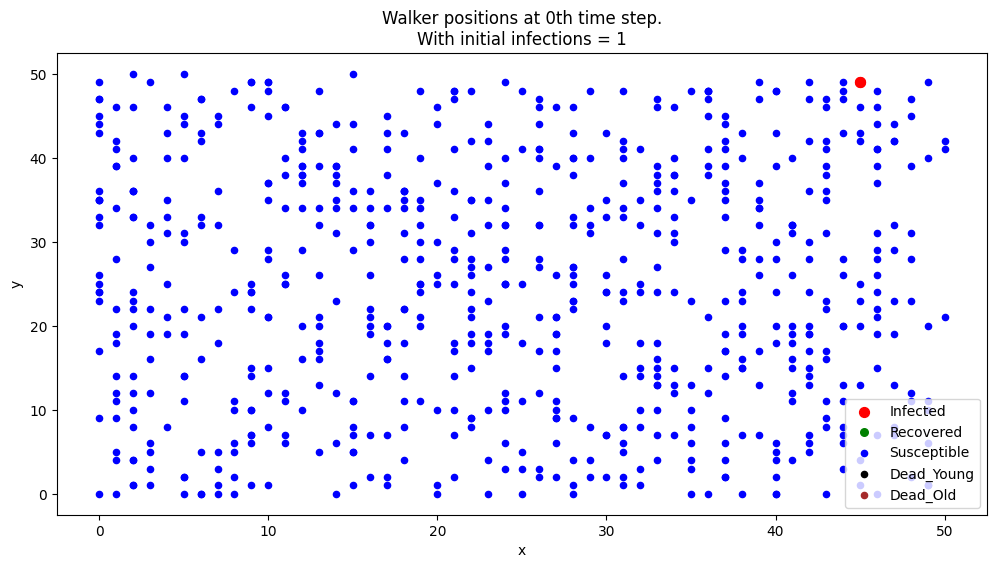

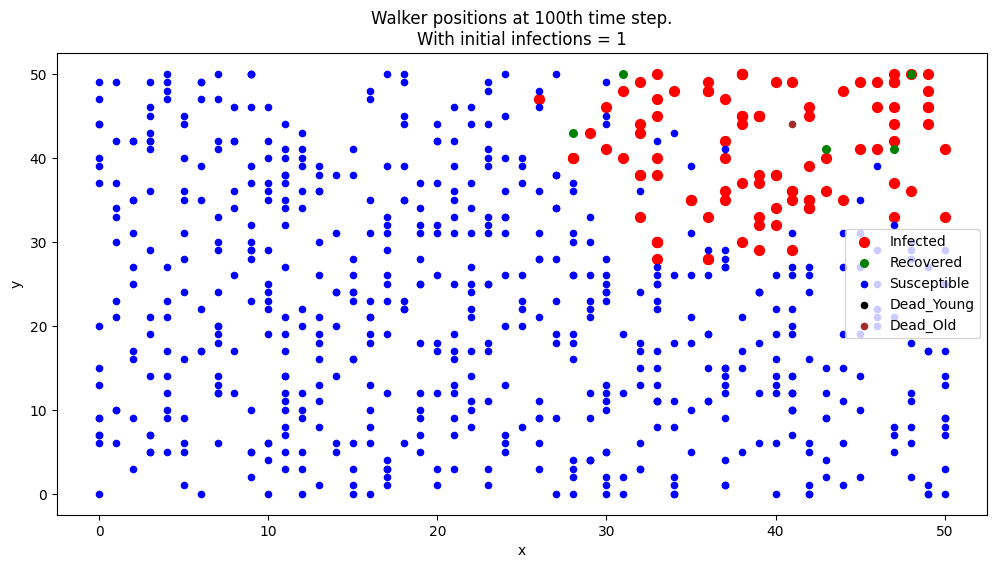

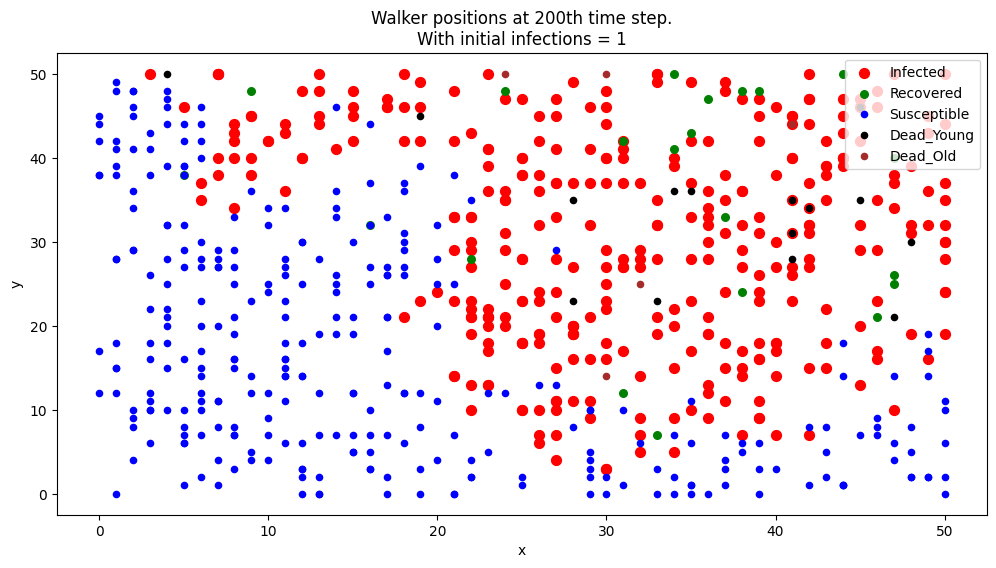

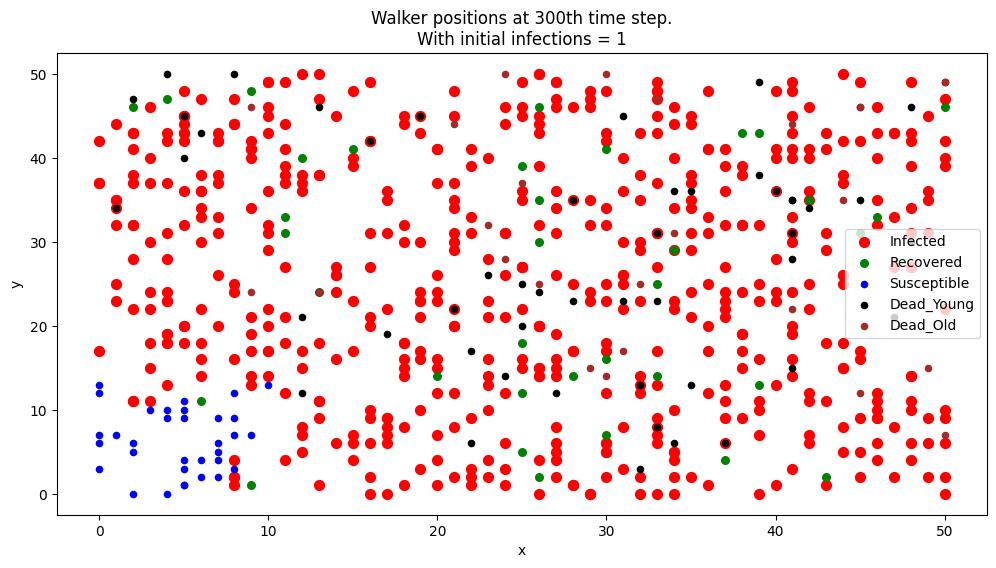

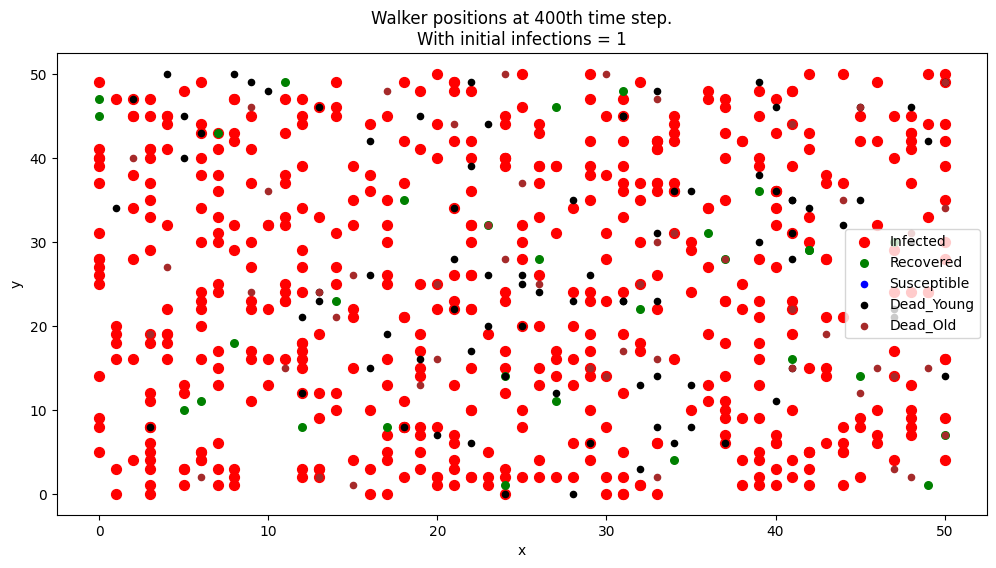

In [12]:
RW = RandomWalkEpidemicSimulator(683, 400, 1,q=0.9, p = 0.005,dt=1, d = 0.001, own_scenario= True)
RW.initial_state()
RW.Show_walkers()

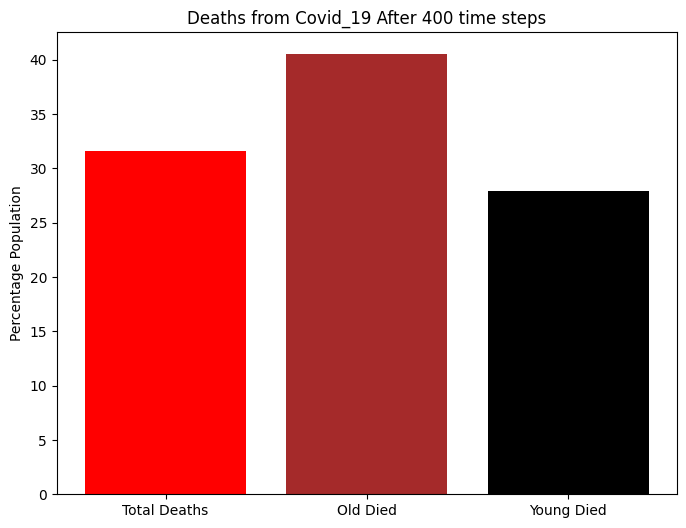

Percent Total Dead:  31.625183016105417 
Percent old dead:  40.5 
Percent Young dead:  27.95031055900621


In [13]:
_, _, _, dead_young, dead_old, dead_total = RW.solver_own_scenario()
percent_dead_total = dead_total[-1]/RW.N*100
percent_old = dead_old[-1]/RW.pop_old*100
percent_young = dead_young[-1]/(RW.N - RW.pop_old)*100
plt.figure(figsize = (8,6))
plt.title('Deaths from Covid_19 After {} time steps'.format(RW.sim_t))
plt.bar('Total Deaths', percent_dead_total, color = 'red')
plt.bar('Old Died', percent_old, color = 'brown')
plt.bar('Young Died', percent_young, color = 'black')
#plt.xlabel('Deaths')
plt.ylabel('Percentage Population')
plt.show()
print('Percent Total Dead: ', percent_dead_total,'\nPercent old dead: ', percent_old, '\nPercent Young dead: ', percent_young)

### Discussion
The barplot above show one random iteration with initially one infected person.
As can be seen about 39% of the total poulutaion dies after 400 time steps. The old people have a higher probability of dying thus it can be seen that out of 200 old people **46.5%** of them died from the disease as compared to 36.2% of the young people.

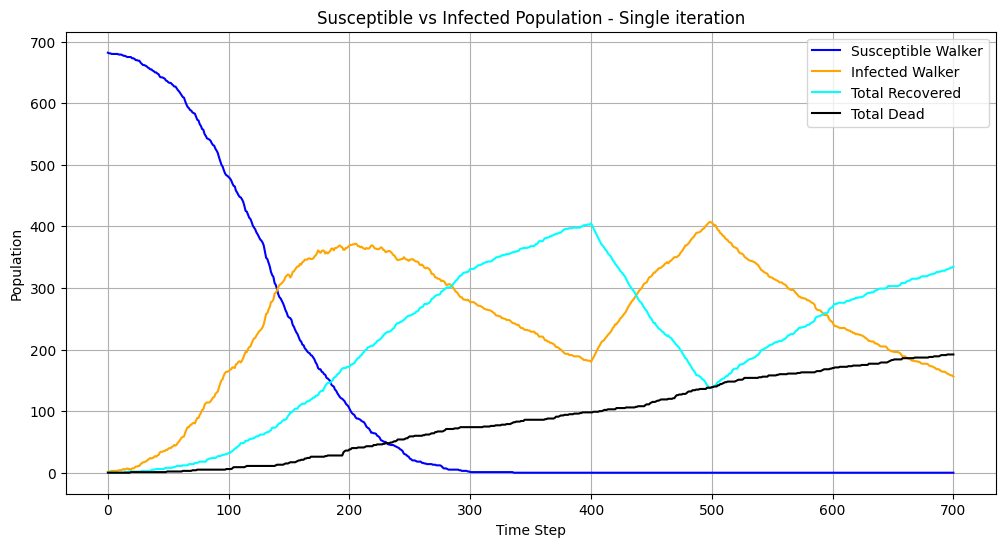

In [14]:
RW = RandomWalkEpidemicSimulator(683, 700, 1,q=0.9, p = 0.005,dt=1, d = 0.001, own_scenario= True)
RW.initial_state()
suscep, infec, rec, dead_young, dead_old, dead_total = RW.solver_own_scenario()
plt.figure(figsize= (12, 6))
plt.title('Susceptible vs Infected Population - Single iteration')
plt.plot(RW.time, suscep, color='blue',label='Susceptible Walker')
plt.plot(RW.time, infec, color='orange',label='Infected Walker')
plt.plot(RW.time, rec, c = 'cyan', label = 'Total Recovered')
plt.plot(RW.time, dead_total, color = 'black', label = 'Total Dead')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

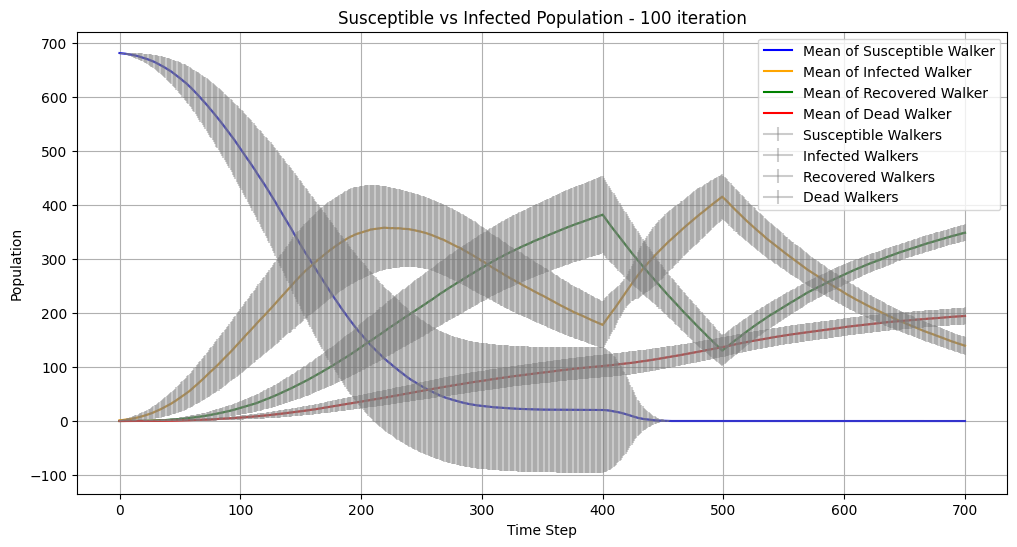

In [15]:
iterations = 100
susceptible_mean, infected_mean, recovered_mean,dead_mean, susceptible_std, infected_std, recovered_std, dead_std = RW.mean_std(iterations)
# Plotting
plt.figure( figsize = (12,6))
plt.title('Susceptible vs Infected Population - 100 iteration')
plt.plot(RW.time,susceptible_mean, color='blue',label='Mean of Susceptible Walker')
plt.plot(RW.time,infected_mean, color='orange',label='Mean of Infected Walker')
plt.plot(RW.time,recovered_mean, color='green',label='Mean of Recovered Walker')
plt.plot(RW.time,dead_mean, color='red',label='Mean of Dead Walker')
plt.errorbar(RW.time, susceptible_mean, susceptible_std, label = 'Susceptible Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, infected_mean, infected_std, label = 'Infected Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, recovered_mean, recovered_std, label = 'Recovered Walkers',alpha=0.4,color='gray')
plt.errorbar(RW.time, dead_mean, dead_std, label = 'Dead Walkers',alpha=0.4,color='gray')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.legend()
plt.grid()

In [16]:
dt = pd.read_csv('https://raw.githubusercontent.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning/master/day_wise.csv')
dt.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


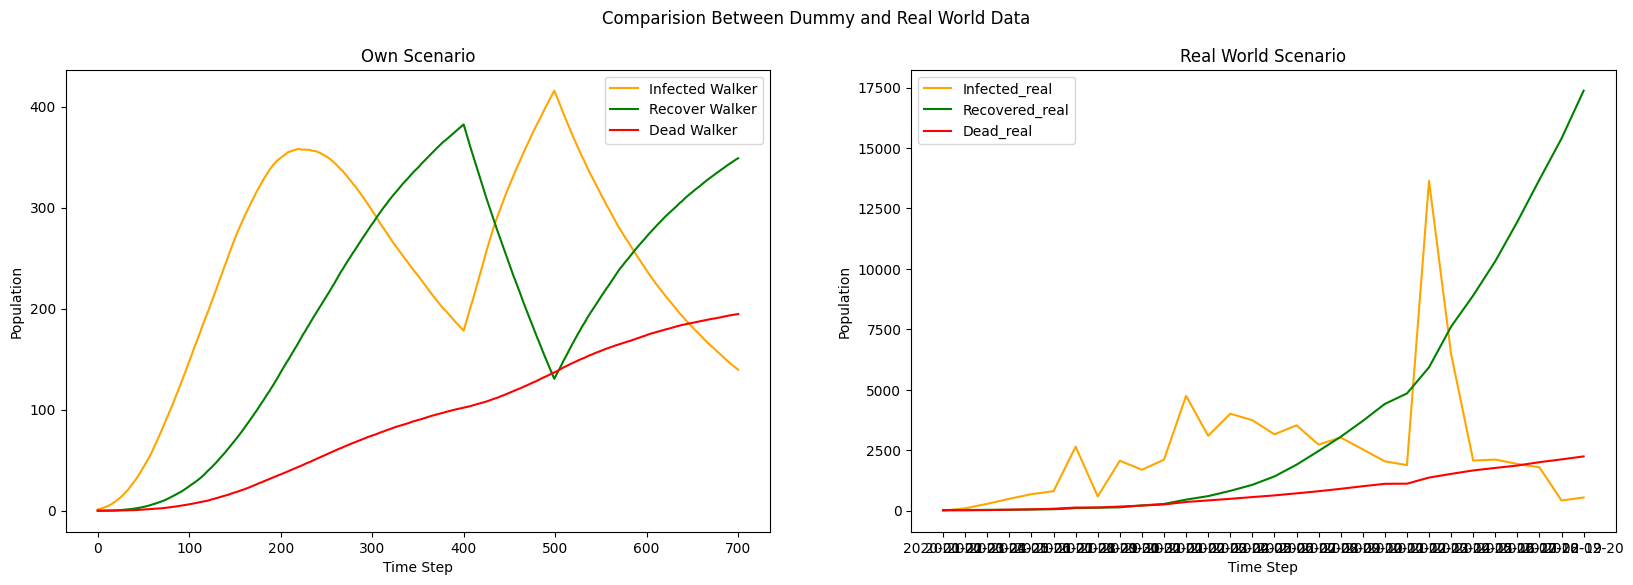

In [17]:
fig, axs = plt.subplots(1,2, figsize = (20,6))
fig.suptitle('Comparision Between Dummy and Real World Data')

axs[0].plot(RW.time, infected_mean, color='orange',label='Infected Walker')
axs[0].plot(RW.time, recovered_mean, color='green',label='Recover Walker')
axs[0].plot(RW.time, dead_mean, color='red',label='Dead Walker')
axs[0].set_title('Own Scenario')
axs[0].set_ylabel('Population')
axs[0].set_xlabel('Time Step')
axs[0].legend()


till_data = 30 # 30 days
axs[1].plot(dt['Date'][:till_data],dt['New cases'][:till_data],color='orange', label = 'Infected_real')
axs[1].plot(dt['Date'][:till_data],dt['Recovered'][:till_data],color='green', label = 'Recovered_real')
axs[1].plot(dt['Date'][:till_data],dt['Deaths'][:till_data],color='red', label = 'Dead_real')
axs[1].set_title('Real World Scenario')
axs[1].set_ylabel('Population')
axs[1].set_xlabel('Time Step')
axs[1].legend()

### Discussion
At first observation a considerable difference can be seen between the two plots, however due to a very small population size as compared to real data the same individuals are getting infected and re-infected, which results in the shape above. The two crests show two different infection waves. In each wave the recovered or remaining susceptible individuals get re-infected with the disease.

<blockquote><h2><b>Conclusion</b></h2></blockquote>

 Developed a "RandomWalkEpidemicSimulator" class to investigate the transmission of Covid 19. The SI model was developed by randomly infecting a small number of walkers in a compartment to observe how the virus spreads from one walker to another as the walkers randomly move on a 2D, lattice grid. Multiple iterations of the SI model have shown that eventually, all susceptible walkers become infected. By increasing the number of initial infection walkers, it can be shown that the infection walker curve quickly stabilizes, indicating that the infection spreads more quickly. In order to compare the results of the random walker study with the analytical solution, an ODE-based SIR model was used and noticed the same trend in curves between both of them. Finally, further scenarios were added to the SIR model by including the age factor, a vaccine facility, and the second wave of COVID 19. The graph demonstrates that older walkers were more frequently infected by virus. Younger walkers had a better chance of recovering than older ones. The second wave of COVID 19 can infect walkers once again.

<blockquote><h2><b>References</b></h2></blockquote>

<pre>
[1] Dynamics of an SIR-Based COVID-19 Model With Linear Incidence Rate, Nonlinear Removal Rate, and Public Awareness, 2021 May.
    https://www.frontiersin.org/articles/10.3389/fphy.2021.634251/full
[2] A SIR model assumption for the spread of COVID-19 in different communities, 2020 Oct.
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321055/#bib0029, 
[3] Coronavirus Goes Randomly Viral, Project 4, Aksel Hiorth